# Рекомендация тарифов

В вашем распоряжении данные о поведении клиентов, которые уже перешли на эти тарифы (из проекта курса «Статистический анализ данных»). Нужно построить модель для задачи классификации, которая выберет подходящий тариф. Предобработка данных не понадобится — вы её уже сделали.

Постройте модель с максимально большим значением *accuracy*. Чтобы сдать проект успешно, нужно довести долю правильных ответов по крайней мере до 0.75. Проверьте *accuracy* на тестовой выборке самостоятельно.

## 1. Откройте и изучите файл

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, f1_score
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
import joblib

In [2]:
df = pd.read_csv('/datasets/users_behavior.csv')

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3214 entries, 0 to 3213
Data columns (total 5 columns):
calls       3214 non-null float64
minutes     3214 non-null float64
messages    3214 non-null float64
mb_used     3214 non-null float64
is_ultra    3214 non-null int64
dtypes: float64(4), int64(1)
memory usage: 125.7 KB


In [4]:
df.describe()

,calls,minutes,messages,mb_used,is_ultra
count,3214.000000,3214.000000,3214.000000,3214.000000,3214.000000
mean,63.038892,438.208787,38.281269,17207.673836,0.306472
std,33.236368,234.569872,36.148326,7570.968246,0.461100
min,0.000000,0.000000,0.000000,0.000000,0.000000
25%,40.000000,274.575000,9.000000,12491.902500,0.000000
50%,62.000000,430.600000,30.000000,16943.235000,0.000000
75%,82.000000,571.927500,57.000000,21424.700000,1.000000
max,244.000000,1632.060000,224.000000,49745.730000,1.000000


## Выводы:
- Всего предоставлено данных о 3214 абонентах, данные полны, типы правильные, обработка не требуется
- Примерно 30% из предоставленных данных абоненты ultra (значение 1 в столбце  is_ultra), соответственно, остальные 70% - smart (значение 0 в столбце  is_ultra)

## 2. Разбейте данные на выборки

In [5]:
# разобьем предоставленные данные случайным образом на три выборки:
# обучающую, валидационную и тестовую, пропорция 3:1:1
# выделим features и targets и поместим данные в словари features и targets с ключами, соотв. выборке
selections_names = ['test', 'validation', 'train']
# random_state_for_split = 234908
random_state_for_split = 12345

dfs = {}
# dfs['all'] = df
dfs['train'], df_buff = train_test_split(df, test_size=.4, random_state=random_state_for_split)
dfs['validation'], dfs['test'] = train_test_split(df_buff, test_size=.5, random_state=random_state_for_split)

features = {}
targets  = {}
for selection in selections_names:
        features[selection] = dfs[selection].drop(['is_ultra'], axis=1)
        targets[selection] = dfs[selection]['is_ultra']
        print(f'Выборка  : {selection}')
        print(f'Признаки : {features[selection].shape}')
        print(f'Цели     : {targets[selection].shape}')
        print()

Выборка  : test
Признаки : (643, 4)
Цели     : (643,)

Выборка  : validation
Признаки : (643, 4)
Цели     : (643,)

Выборка  : train
Признаки : (1928, 4)
Цели     : (1928,)



## 3. Исследуйте модели

In [6]:
# создадим функцию возвращающую accuracy модели на любой выборке (по умолчанию validation)
def get_accuracy(model, selection='validation'):
    return model.score(features[selection], targets[selection])

In [7]:
# исследование решающего дерева
tree_models_accuracy = pd.Series(dtype=float)
#tree_models_f1_score = pd.Series(dtype=float)
tree_models = pd.Series(dtype=object)

lo_depth = 1
hi_depth = 25
random_state_for_models = 12345 

for depth in range(lo_depth, hi_depth + 1):
    model = DecisionTreeClassifier(random_state=random_state_for_models, max_depth=depth)
    model.fit(features['train'], targets['train'])
    tree_models_accuracy.loc[depth] = get_accuracy(model)
    #tree_models_f1_score.loc[depth] = get_f1(model)
    tree_models.loc[depth] = model

In [8]:
# запомним параметры лучшего дерева
tree_best_depth = tree_models_accuracy.idxmax()
tree_best_accuracy = tree_models_accuracy[tree_best_depth]

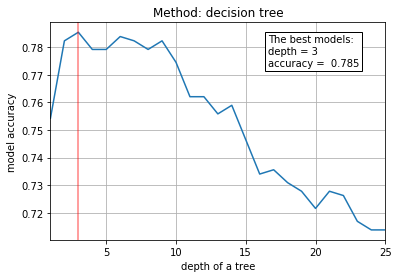

In [9]:
# выведем график доли правильных ответов от глубины, вертикалью обозначим наилучшую по accuracy модель
ax = tree_models_accuracy.plot(grid=True, title='Method: decision tree')
ax1 = ax.set(ylabel='model accuracy', xlabel='depth of a tree')
plt.axvline(x=tree_best_depth, color = 'r', alpha=.5)
#ax1 = tree_models_f1_score.plot(ax=ax, color = 'g', alpha=.3, grid=True)
annotation = 'The best models: \n' + f'depth = {tree_best_depth}\n' + f'accuracy = {tree_best_accuracy:>6.3f}'
n=ax.annotate(annotation, xy=(.65, .8), xycoords=ax.transAxes, bbox=dict(boxstyle='square', fc='white', ec='black'))

In [10]:
# исследование случайного леса
# мы будем изучать лес с разными шагами по гиперпараметру n_estimators и при разной максимальной глубине деревьев
# поэтому создадим функцию, которая при заданных пределах и шаге n_estimators возвращает лучшую модель
# и рисует график accuracy моделей для визуальной оценки
def forest_research(random_state_for_models, lo_est, hi_est, step, max_depth=None, show_best=True):
    #start = time.time()
    models_accuracy = pd.Series(dtype=float) # создадим серию для запоминания accuracy каждой из созданных моделей
    models = pd.Series(dtype=object) # создадим серию для запоминания каждой из созданных моделей
    for n_est in range(lo_est, hi_est + 1, step): # в цикле создаем модели, меряем accuracy каждой, запоминаем все в сериях
        model = RandomForestClassifier(random_state=random_state_for_models, n_estimators=n_est, max_depth=max_depth)
        model.fit(features['train'], targets['train'])
        models_accuracy.loc[n_est] = get_accuracy(model)
        models.loc[n_est] = model
    best_param = models_accuracy.idxmax() # определяем модель с лучшей accuracy
    best_accuracy = models_accuracy[best_param]
    ax = models_accuracy.plot(grid=True, title=f'Method: random forest, max_depth = {max_depth}')
    ax1 = ax.set(ylabel='model accuracy', xlabel='number of estimators')
    span = hi_est - lo_est
    if span > 150:
        xticks_step = 20
    elif span > 100:
        xticks_step = 10
    elif span > 40:
         xticks_step = 5
    elif span > 15:
         xticks_step = 2  
    else:
        xticks_step = 1
    x_min = lo_est - lo_est % xticks_step
    x_max = hi_est - hi_est % xticks_step + 1
    plt.xticks(range(x_min, x_max, xticks_step))
    if show_best:
        plt.axvline(x=best_param, color = 'r', alpha=.5)
        annotation = 'The best model: \n' + f'n_est = {best_param}\n' + f'accuracy = {best_accuracy:>6.3f}'
        n=ax.annotate(annotation, xy=(.65, .2), xycoords=ax.transAxes, bbox=dict(boxstyle='square', fc='white', ec='black'))
    plt.show()
    #print(time.time() - start)
    return best_param, best_accuracy, models[best_param]

In [11]:
random_state_for_models = 12345
# будем сохранять лучшую модель леса и ее accuracy в отдельную мультииндексную серию
index = pd.MultiIndex.from_tuples([(0,0)], names=['depth', 'estimators'])
best_forest_accuracy = pd.Series(dtype=float, index=index) 
best_forest_models = pd.Series(dtype=object, index=index)

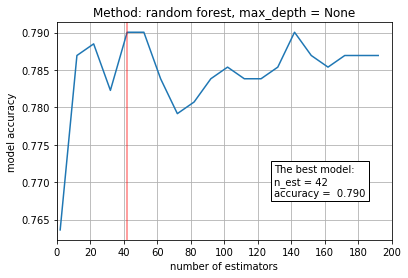

In [12]:
best_no_est, best_accuracy, best_model = forest_research(random_state_for_models, 2, 200, 10)

best_forest_accuracy.loc[(0, best_no_est)] = best_accuracy
best_forest_models.loc[(0, best_no_est)] = best_model

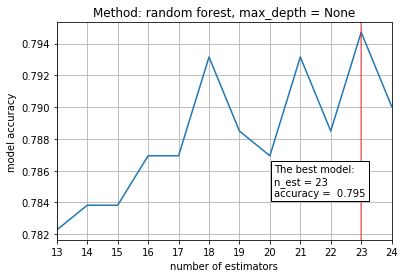

In [13]:
# на первом шаге мы исследовали модели с очень большим шагом по числу оценщиков
# сейчас исследуем более внимательно заметные локальные максимумы
best_no_est, best_accuracy, best_model = forest_research(random_state_for_models, 13, 24, 1)
best_forest_accuracy.loc[(0, best_no_est)] = best_accuracy
best_forest_models.loc[(0, best_no_est)] = best_model

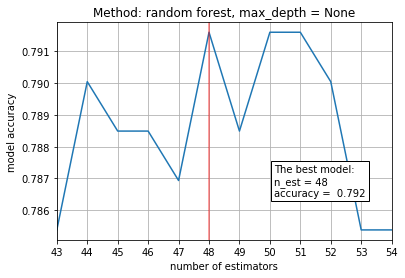

In [14]:
best_no_est, best_accuracy, best_model = forest_research(random_state_for_models, 43, 54, 1)
best_forest_accuracy.loc[(0, best_no_est)] = best_accuracy
best_forest_models.loc[(0, best_no_est)] = best_model

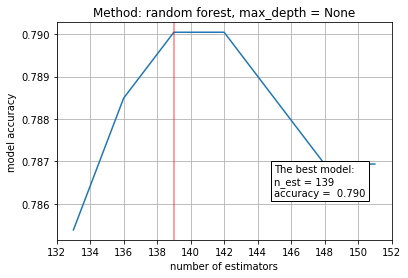

In [15]:
best_no_est, best_accuracy, best_model = forest_research(random_state_for_models, 133, 152, 3)
best_forest_accuracy.loc[(0, best_no_est)] = best_accuracy
best_forest_models.loc[(0, best_no_est)] = best_model

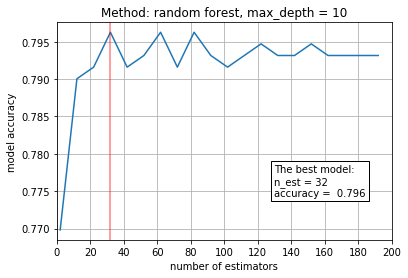

In [16]:
# ограничим глубину деревьев 10 уровнями
best_no_est, best_accuracy, best_model = forest_research(random_state_for_models, 2, 200, 10, max_depth=10)
best_forest_accuracy.loc[(10, best_no_est)] = best_accuracy
best_forest_models.loc[(10, best_no_est)] = best_model

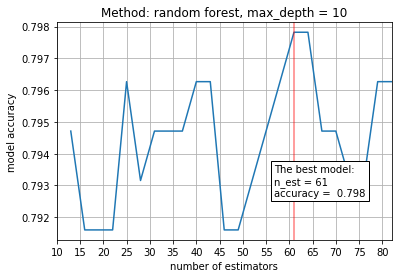

In [17]:
best_no_est, best_accuracy, best_model = forest_research(random_state_for_models, 13, 83, 3, max_depth=10)
best_forest_accuracy.loc[(10, best_no_est)] = best_accuracy
best_forest_models.loc[(10, best_no_est)] = best_model

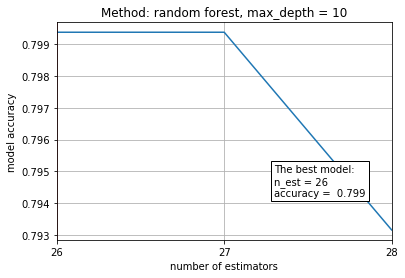

In [18]:
best_no_est, best_accuracy, best_model = forest_research(random_state_for_models, 26, 28, 1, max_depth=10)
best_forest_accuracy.loc[(10, best_no_est)] = best_accuracy
best_forest_models.loc[(10, best_no_est)] = best_model

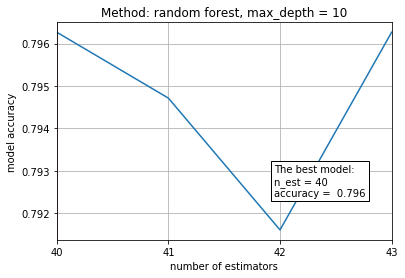

In [19]:
best_no_est, best_accuracy, best_model = forest_research(random_state_for_models, 40, 43, 1, max_depth=10)
best_forest_accuracy.loc[(10, best_no_est)] = best_accuracy
best_forest_models.loc[(10, best_no_est)] = best_model

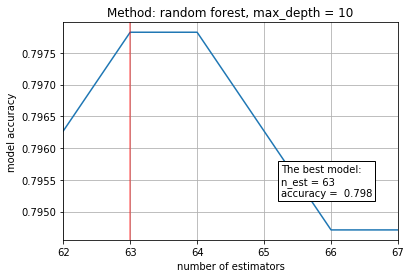

In [20]:
best_no_est, best_accuracy, best_model = forest_research(random_state_for_models, 62, 67, 1, max_depth=10)
best_forest_accuracy.loc[(10, best_no_est)] = best_accuracy
best_forest_models.loc[(10, best_no_est)] = best_model

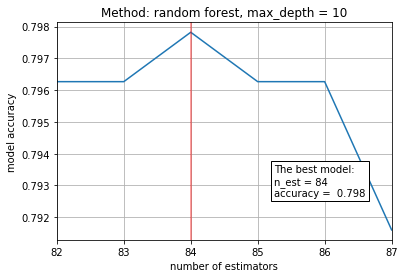

In [21]:
best_no_est, best_accuracy, best_model = forest_research(random_state_for_models, 82, 87, 1, max_depth=10)
best_forest_accuracy.loc[(10, best_no_est)] = best_accuracy
best_forest_models.loc[(10, best_no_est)] = best_model

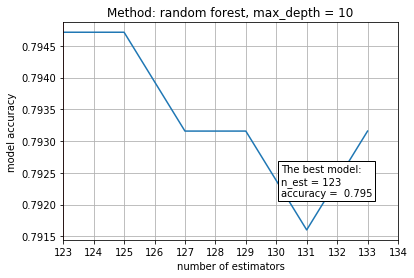

In [22]:
best_no_est, best_accuracy, best_model = forest_research(random_state_for_models, 123, 134, 2, max_depth=10)
best_forest_accuracy.loc[(10, best_no_est)] = best_accuracy
best_forest_models.loc[(10, best_no_est)] = best_model

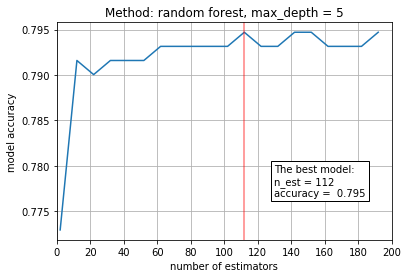

In [23]:
# ограничим глубину деревьев 5 уровнями
best_no_est, best_accuracy, best_model = forest_research(random_state_for_models, 2, 200, 10, max_depth=5)
best_forest_accuracy.loc[(5, best_no_est)] = best_accuracy
best_forest_models.loc[(5, best_no_est)] = best_model

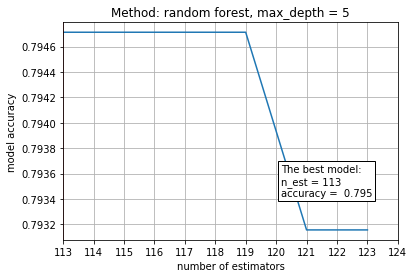

In [24]:
best_no_est, best_accuracy, best_model = forest_research(random_state_for_models, 113, 124, 2, max_depth=5)
best_forest_accuracy.loc[(5, best_no_est)] = best_accuracy
best_forest_models.loc[(5, best_no_est)] = best_model

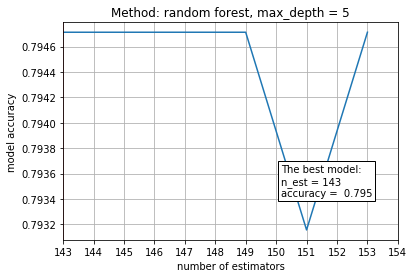

In [25]:
best_no_est, best_accuracy, best_model = forest_research(random_state_for_models, 143, 154, 2, max_depth=5)
best_forest_accuracy.loc[(5, best_no_est)] = best_accuracy
best_forest_models.loc[(5, best_no_est)] = best_model

In [26]:
best_forest_accuracy

depth  estimators
0      0                  NaN
       42            0.790047
       23            0.794712
       48            0.791602
       139           0.790047
10     32            0.796267
       61            0.797823
       26            0.799378
       40            0.796267
       63            0.797823
       84            0.797823
       123           0.794712
5      112           0.794712
       113           0.794712
       143           0.794712
dtype: float64

In [27]:
the_best_forest_model_index = best_forest_accuracy.idxmax()
the_best_forest_model_index

(10, 26)

In [28]:
# мы получили параметры наилучшей модели случайного леса по доли правильных ответов (accuracy)
# для дальнейших исследований сохраним параметры лучшего леса не только для лучшей модели, 
# но и для лучших по accuracy для неограниченной глубины и для максимальной глубины в 5 уровней
best_3_forest_models_indexes = [(10, 26), (5, 112), (0, 23)]

In [29]:
# исследование логистической регрессии
random_state_for_models = 12345
logistic_model = LogisticRegression(random_state=random_state_for_models, solver='liblinear')
logistic_model.fit(features['train'], targets['train'])
print('Доля правильных ответов: ', get_accuracy(logistic_model))

Доля правильных ответов:  0.7589424572317263


## Выводы:
- Мы исследовали три метода классификации: модели решающего дерева, случайного леса и логистической регрессии.
- Для оценки качества различных моделей при варьировании некоторых гиперпараметров использовали метрику доли правильных ответов на валидационной выборке (accuracy).
- Для решающего дерева мы варьрировали максимальную глубину, для случайного леса - число оценщиков при неограниченном кол-ве уровней и при ограничении на 10 и 5 уровней.
- Наибольшой доли правильных ответов мы добились для модели случайного леса при 26 оценщиках и ограничении глубины в 10 уровней. Доля правильных ответов лучшей модели составила почти 0.8 (0.799)

## 4. Проверьте модель на тестовой выборке

In [30]:
# для отображения accuracy для разных выборок и для разных моделей создадим таблицу
# каждая модель - отдельный столбец в таблице отображения
rows = []
for selection in selections_names:
    rows.append(f'Accuracy, {selection} data:')   

# при проверке на адекватность будет интересно сравнить F1 метрику для разных моделей, добавим в общую таблицу
row_f1_score = 'F1 score, test data'

show_accuracy_table = pd.DataFrame([], index=rows)

# создадим функцию, считающую accuracy на разных моделях и добавляющую полученные accuracy в общую таблицу
def add_to_accuracy_table(model, col_name):
    for i, selection in enumerate(selections_names):
        predictions = model.predict(features[selection])
        show_accuracy_table.loc[rows[i], col_name] = accuracy_score(targets[selection], predictions)
        # при проверке на адекватность будет интересно сравнить F1 метрику для разных моделей, добавим в общую таблицу
        if selection == 'test':
            show_accuracy_table.loc[row_f1_score, col_name] = f1_score(targets[selection], predictions, average='macro')

In [31]:
# считаем долю правильных ответов на разных выборках для лучшего дерева
add_to_accuracy_table(tree_models[tree_best_depth], f'Tree, max_depth={tree_best_depth}')
# считаем долю правильных ответов на разных выборках для лучших моделей леса
for index in best_3_forest_models_indexes:
    depth, n_est = index
    if depth == 0:
        depth = 'None'
    add_to_accuracy_table(best_forest_models[index], f'Forest, max_depth={depth}, n_estimators={n_est}')
# считаем долю правильных ответов на разных выборках для логистической регресии
add_to_accuracy_table(logistic_model, 'logistic regression')

In [32]:
show_accuracy_table.drop(index=row_f1_score)

,"Tree, max_depth=3","Forest, max_depth=10, n_estimators=26","Forest, max_depth=5, n_estimators=112","Forest, max_depth=None, n_estimators=23",logistic regression
"Accuracy, test data:",0.779160,0.799378,0.791602,0.780715,0.740280
"Accuracy, validation data:",0.785381,0.799378,0.794712,0.794712,0.758942
"Accuracy, train data:",0.807573,0.894710,0.824170,0.993776,0.750519


##  Выводы:
- Лучшая модель по доле правильных ответов - случайный лес при ограничении максимальной глубины 10 уровнями и числом оценщиков в 26 подтвердил свой лучший результат и на тестовой выборке.
- Сравнение доли правильных ответов на обучающих и проверочных выборках для разных гиперпараметров случайного леса демонстрирует, что при ограничении числа уровней падает доля правильных ответов на обучающей выборке, но зато получаются более высокие результаты на проверочных выборках. Это, как я думаю, свидетельствует о переобучении моделей случайного леса при неограниченном числе уровней.

## 5. (бонус) Проверьте модели на адекватность

In [33]:
# простейшей dummy моделью прогноза будет вариант, когда мы будем всегда предсказывать 0, 
# поскольку в начальном наборе нулей около 70%, значит, accuracy должны быть для dummy прогноза в р-не 0.7
# тем не менее создадим dummy прогнозы, чтобы сравнить модели и по метрике F1 
dummy_predictions = {}
for selection in selections_names:
    dummy_predictions[selection] = pd.Series(0, index=range(len(targets[selection])))

In [34]:
for i, selection in enumerate(selections_names):
    show_accuracy_table.loc[rows[i], 'dummy'] = accuracy_score(targets[selection], dummy_predictions[selection])

show_accuracy_table.loc[row_f1_score, 'dummy'] = f1_score(targets['test'], dummy_predictions['test'], average='macro')


/opt/conda/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [35]:
show_accuracy_table

,"Tree, max_depth=3","Forest, max_depth=10, n_estimators=26","Forest, max_depth=5, n_estimators=112","Forest, max_depth=None, n_estimators=23",logistic regression,dummy
"Accuracy, test data:",0.779160,0.799378,0.791602,0.780715,0.740280,0.684292
"Accuracy, validation data:",0.785381,0.799378,0.794712,0.794712,0.758942,0.706065
"Accuracy, train data:",0.807573,0.894710,0.824170,0.993776,0.750519,0.692427
"F1 score, test data",0.709424,0.745431,0.727962,0.735440,0.596301,0.406279


## Выводы:
- По доле правильных ответов (accuracy) логистическая регрессия продемонстрировала худший результат, хотя она и превзошла псевдомодель, которая просто всегда выдает самый распространенный результат исходного набора.
- По валидационной выборке мы определили лучшую (по доле правильных ответов) модель - случайный лес с 26 деревьями и ограничением максимальной глубины 10 уровнями. Эта модель продемонстрировала наивысшую долю правильных ответов и по тестовой выборке, при этом полученное значение доли правильных ответов на тестовой выборке значительно превзошло этот показатель в псевдомодели.
- Легко видеть, что если бы в нашем наборе данных smart абонентов было бы еще больше, например, 90%, по доле правильных ответов ни одна из обученных моделей не смогла бы превзойти псевдомодель, accuracy которой был бы на уровне 90%. Для классифицирования данных, в которых разные классы имеют существенно отличающиеся размеры (в наших данных классы делились в пропорции 70 на 30), надо применять другие метрики качества. Поэтому мы также сравнили F1 метрику для разных моделей (усредняли F1-меру по двум категориям абонентов, считая что F1-мера каждой категории абонентов одинаково важна). Для псевдомодели такая средняя F1-мера составила 0.4, подтверждая низкую ценность такой модели прогноза (заметим, что F1-мера для smart-абонентов вообще равна 0), для остальных моделей метрика F1 в целом подтвердила ранжирование, которые мы сделали изначально по метрике accuracy, хотя отставание логистической регрессии по F1-мере более заметно.